<img src='./img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>


<br> <a href="3_S6_Tracks.ipynb">3 - S6 tracks</a><span style="float:right;"><a href="./5_S6_Waveforms.ipynb">5 - S6 waveforms >></a>  

## Compute corrected sea surface heights & anomalies from Sentinel-6 ##

Here we are going to do something fundamental with our altimetry data; calculating sea surface height from range and satellite altitude, and performing the relevant atmospheric, tidal and geoid corrections. Athough, sea surface height anomaly (SSHA) is provided within the data file we will also calculate it, for our interest.

### Import libraries and define input data

In [1]:
import os
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import dates
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.rcParams["figure.figsize"] = (16,10)
plt.ioff()
matplotlib.rcParams.update({'font.size': 16})

To help to find your data, please complete the MYPATH variable below with the output generated by the /Configuration_Testing/Data_Path_Checker.ipynb Jupyter notebook in the Configuration_Testing folder. 

In [2]:
# e.g. MYPATH = os.path.join("C:/","Users","me","Desktop")
#MYPATH=os.getcwd()
MYPATH = ''

### Define our input data

In [3]:
input_root = os.path.join(MYPATH,'s6_data')
#hr file !! check production date in folder name
#input_path = 'S6A_P4_2__HR______20211015T182929_20211015T192542_20211016T101339_3373_034_126_063_EUM__OPE_ST_F03.SEN6'
#standard file
#input_file = 'S6A_P4_2__HR_STD__ST_034_126_20211015T182929_20211015T192542_F03.nc'

#lr file
input_path = 'S6A_P4_2__LR______20211015T182929_20211015T192542_20211016T101339_3373_034_126_063_EUM__OPE_ST_F03.SEN6'
#standard file
input_file = 'S6A_P4_2__LR_STD__ST_034_126_20211015T182929_20211015T192542_F03.nc'

my_file    = os.path.join(input_root,input_path,input_file)
ncku = xr.open_dataset(my_file, group='data_01/ku')
nc = xr.open_dataset(my_file, group='data_01')

These are the variables we are going to use:

NB. corrected sea surface height =
                                  Altitude 
                                  - range
                                  - atmosphere propagation corrections (dry/wet troposphere, ionosphere electrons)
                                  - tides (ocean, solid earth and pole)
                                  - atmospheric loading (pressure & hf winds)
                                  - sea state bias

then, depending on the reference you want to work with respect to, you can also remove either mean sea surface (to get sea level anomalies; SLAs) or the geoid (to get absolute dynamic topography; ADT), or nothing (to get SSH with respect to the ellipsoid).  For ADT, you can also add the mean topography instead of removing the geoid.

Below we define the variables we need to compute a corrected sea surface height and anomalies. The computation here is done with 1 Hz data with corrections dedicated to open ocean; 

Over coastal areas some correction fields would be different, such as the wet tropospheric correction (not from radiometer). Some corrections are only provided at 1 Hz, since their resolution can't be higher, but they still must be applied for a computation at 20 Hz, though. So you have to use 20 times the 1 Hz value. 

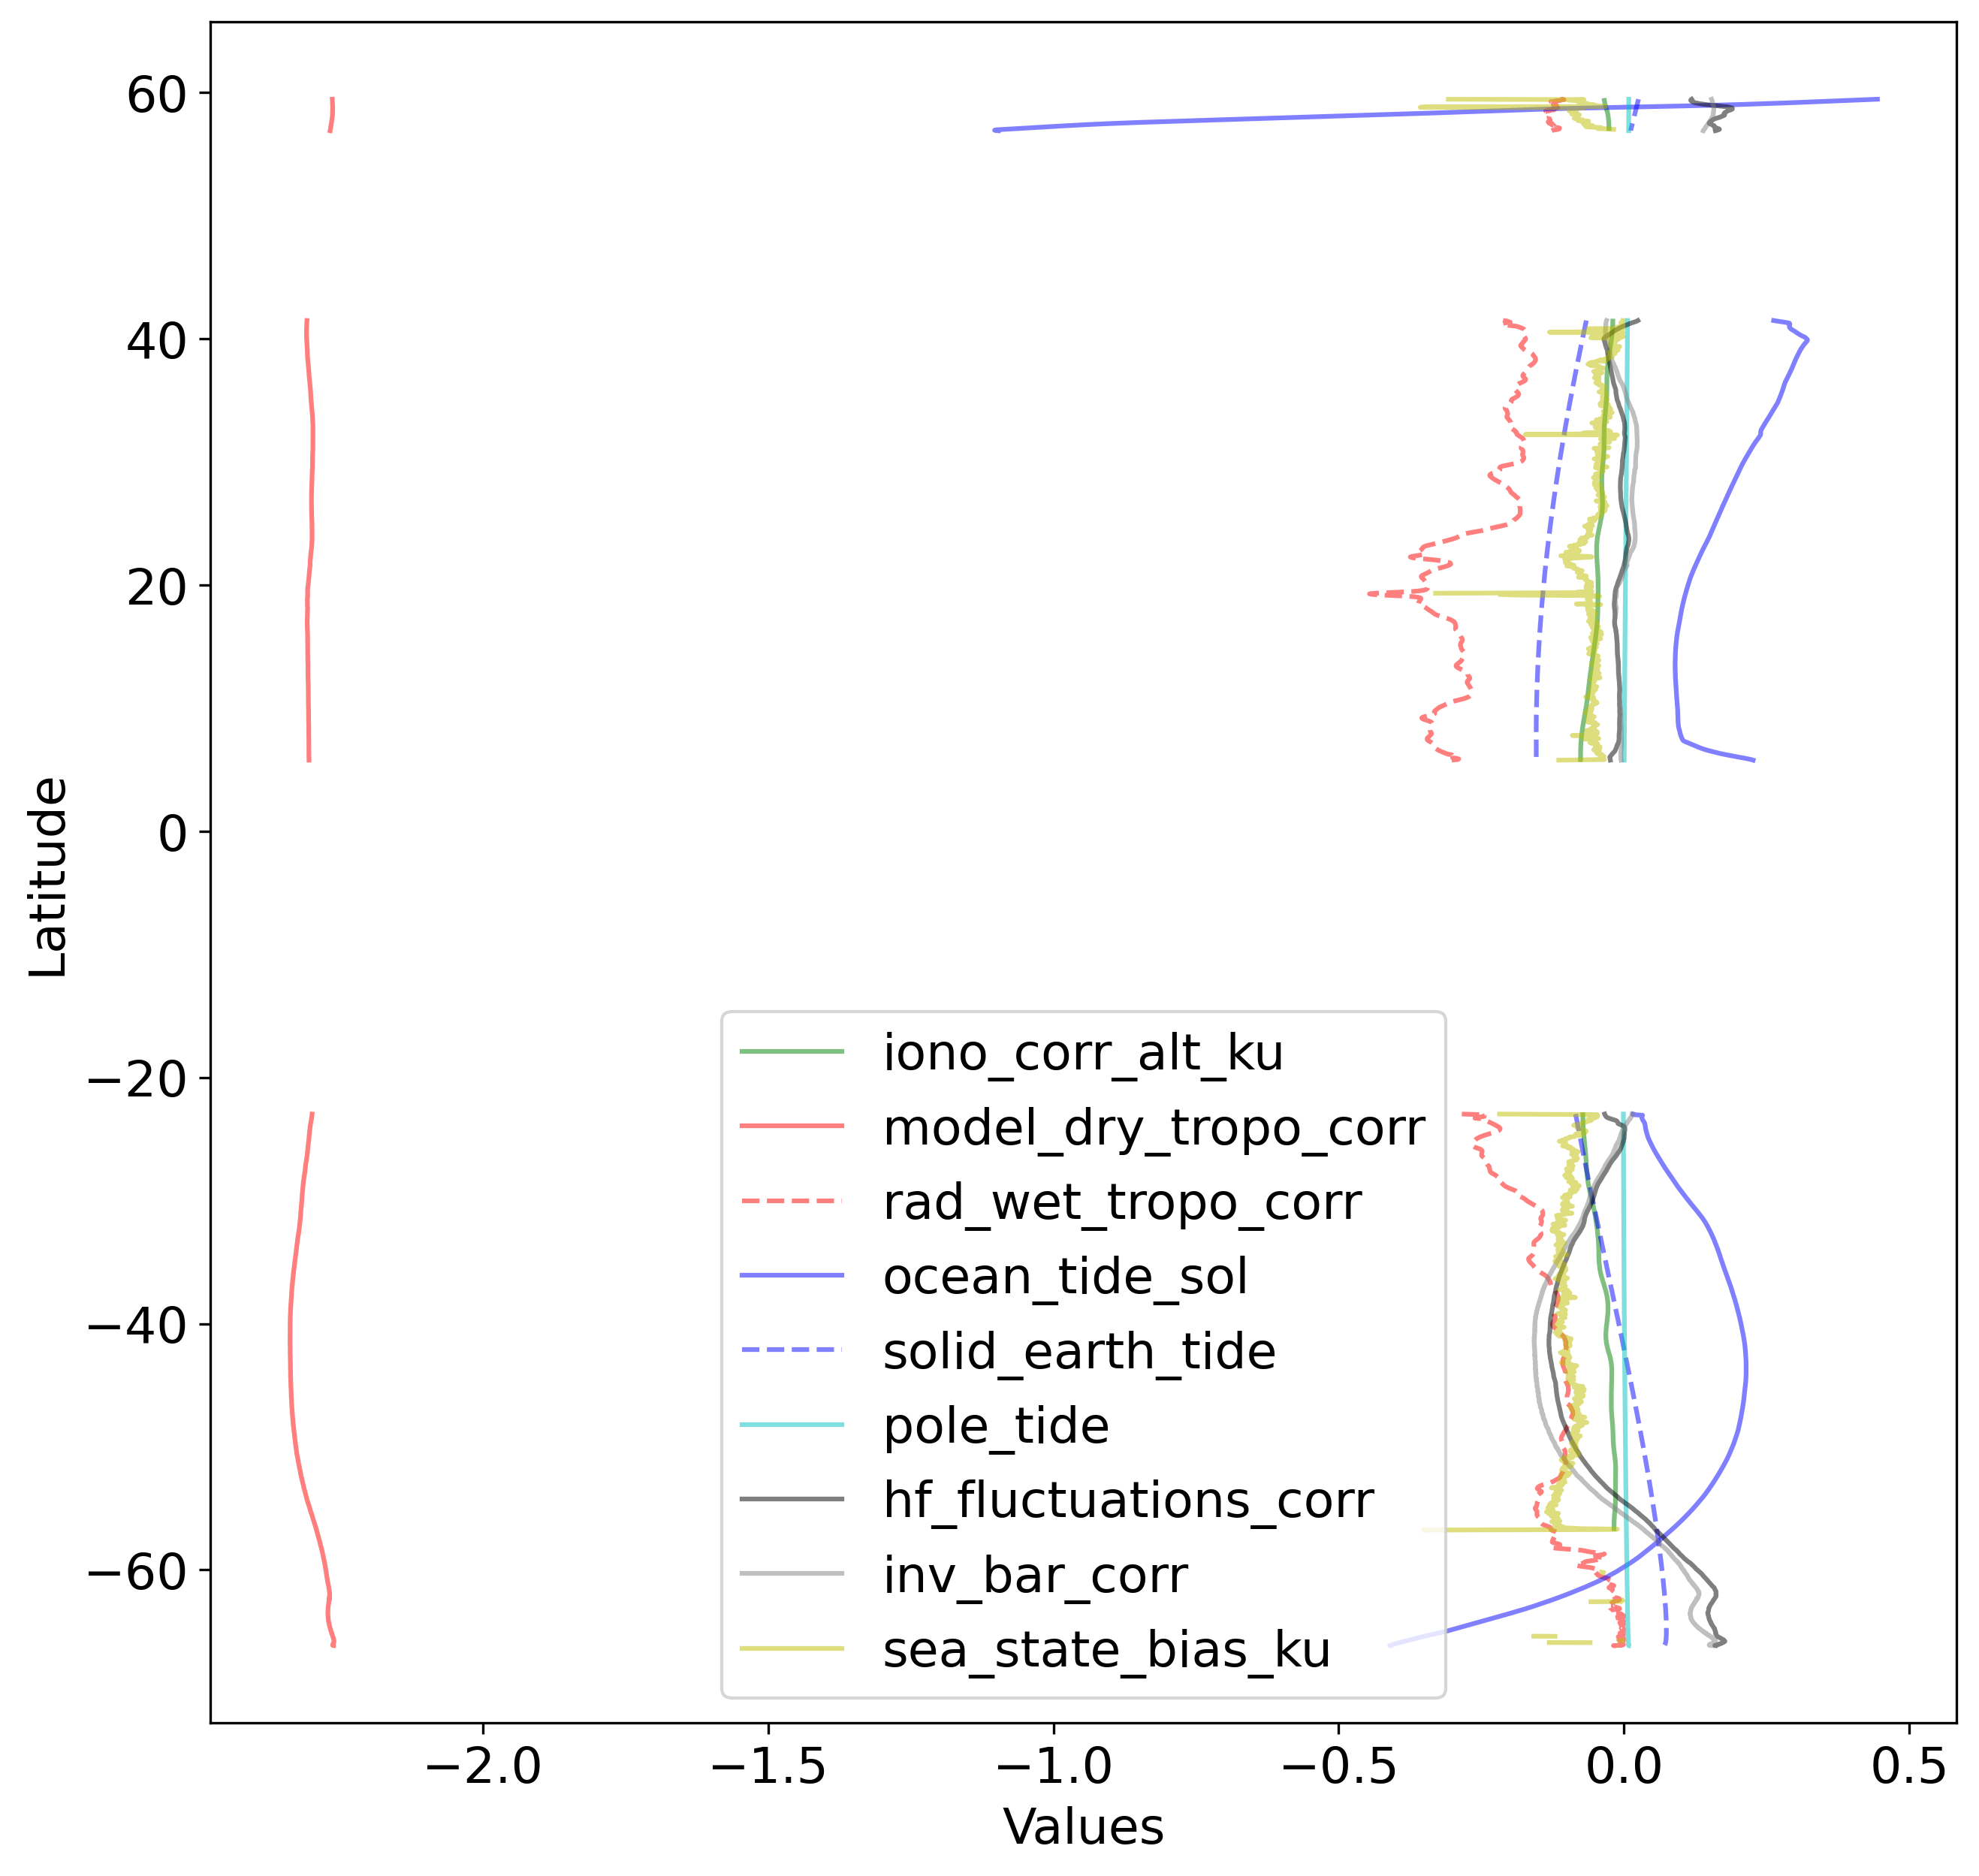

In [4]:
lat = nc.variables['latitude'][:]
lon = nc.variables['longitude'][:]
range_ku = ncku.variables['range_ocean'][:]
alt = nc.variables['altitude'][:]
#atmosphere propagation corrections !! iono correction is NOT in the Ku folder
model_dry_tropo_corr = nc.variables['model_dry_tropo_cor_zero_altitude'][:]
rad_wet_tropo_corr = nc.variables['rad_wet_tropo_cor'][:]
iono_corr_alt_ku = nc.variables['iono_cor_alt_filtered'][:]
#tides - tide model are numbered
ocean_tide_sol = nc.variables['ocean_tide_sol2'][:]
solid_earth_tide = nc.variables['solid_earth_tide'][:]
ocean_tide_non_eq = nc.variables['ocean_tide_non_eq'][:]
internal_tide = nc.variables['internal_tide'][:]
pole_tide = nc.variables['pole_tide'][:]
#atmospheric loading, sea state bias !! Sea state bias frequency-dependent
#hf_fluctuations_corr is dac for NTC/STC off line products, inv_bar_cor for NRT products
hf_fluctuations_corr = nc.variables['dac'][:]
inv_bar_corr = nc.variables['inv_bar_cor'][:]
sea_state_bias_ku = ncku.variables['sea_state_bias'][:]
#reference surfaces ; mean sea surface are numbered
mean_sea_surface = nc.variables['mean_sea_surface_sol1'][:]
mean_topography = nc.variables['mean_dynamic_topography'][:]
geoid = nc.variables['geoid'][:]
# surface class flag
surface_type = nc.variables['surface_classification_flag'][:]

# geophysical variables
swh_ku = ncku.variables['swh_ocean'][:]
sig0_ku = ncku.variables['sig0_ocean'][:]
wind_speed_alt = nc.variables['wind_speed_alt'][:]

nc.close()
ncku.close()

alph = 0.5

# flag out non-ocean values
alt[surface_type != 0.0] = np.nan
range_ku[surface_type != 0.0] = np.nan

iono_corr_alt_ku[surface_type != 0.0] = np.nan
model_dry_tropo_corr[surface_type != 0.0] = np.nan
rad_wet_tropo_corr[surface_type != 0.0] = np.nan
ocean_tide_sol[surface_type != 0.0] = np.nan
solid_earth_tide[surface_type != 0.0] = np.nan
ocean_tide_non_eq[surface_type != 0.0] = np.nan
internal_tide[surface_type != 0.0] = np.nan
pole_tide[surface_type != 0.0] = np.nan
hf_fluctuations_corr[surface_type != 0.0] = np.nan
inv_bar_corr[surface_type != 0.0] = np.nan
sea_state_bias_ku[surface_type != 0.0] = np.nan

#visualize the variables above
fig = plt.figure(figsize=(10, 10), dpi=300)
ax = plt.subplot(1,1,1)
p1, = ax.plot(iono_corr_alt_ku, lat, 'g', label='iono_corr_alt_ku', alpha=alph)
p2, = ax.plot(model_dry_tropo_corr, lat, 'r', label='model_dry_tropo_corr', alpha=alph)
p3, = ax.plot(rad_wet_tropo_corr, lat, 'r--', label='rad_wet_tropo_corr', alpha=alph)
p4, = ax.plot(ocean_tide_sol, lat, 'b', label='ocean_tide_sol', alpha=alph)
p5, = ax.plot(solid_earth_tide, lat,  'b--', label='solid_earth_tide', alpha=alph)
p6, = ax.plot(pole_tide, lat, 'c', label='pole_tide', alpha=alph)
p7, = ax.plot(hf_fluctuations_corr, lat, 'k', label='hf_fluctuations_corr', alpha=alph)
p8, = ax.plot(inv_bar_corr, lat, '0.5', label='inv_bar_corr', alpha=alph)
p9, = ax.plot(sea_state_bias_ku, lat, 'y', label='sea_state_bias_ku', alpha=alph)

plt.xlabel('Values', fontsize=16)
plt.ylabel('Latitude', fontsize=16)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels)
plt.savefig('S6_SSH_calculation_corrections')

plt.show()

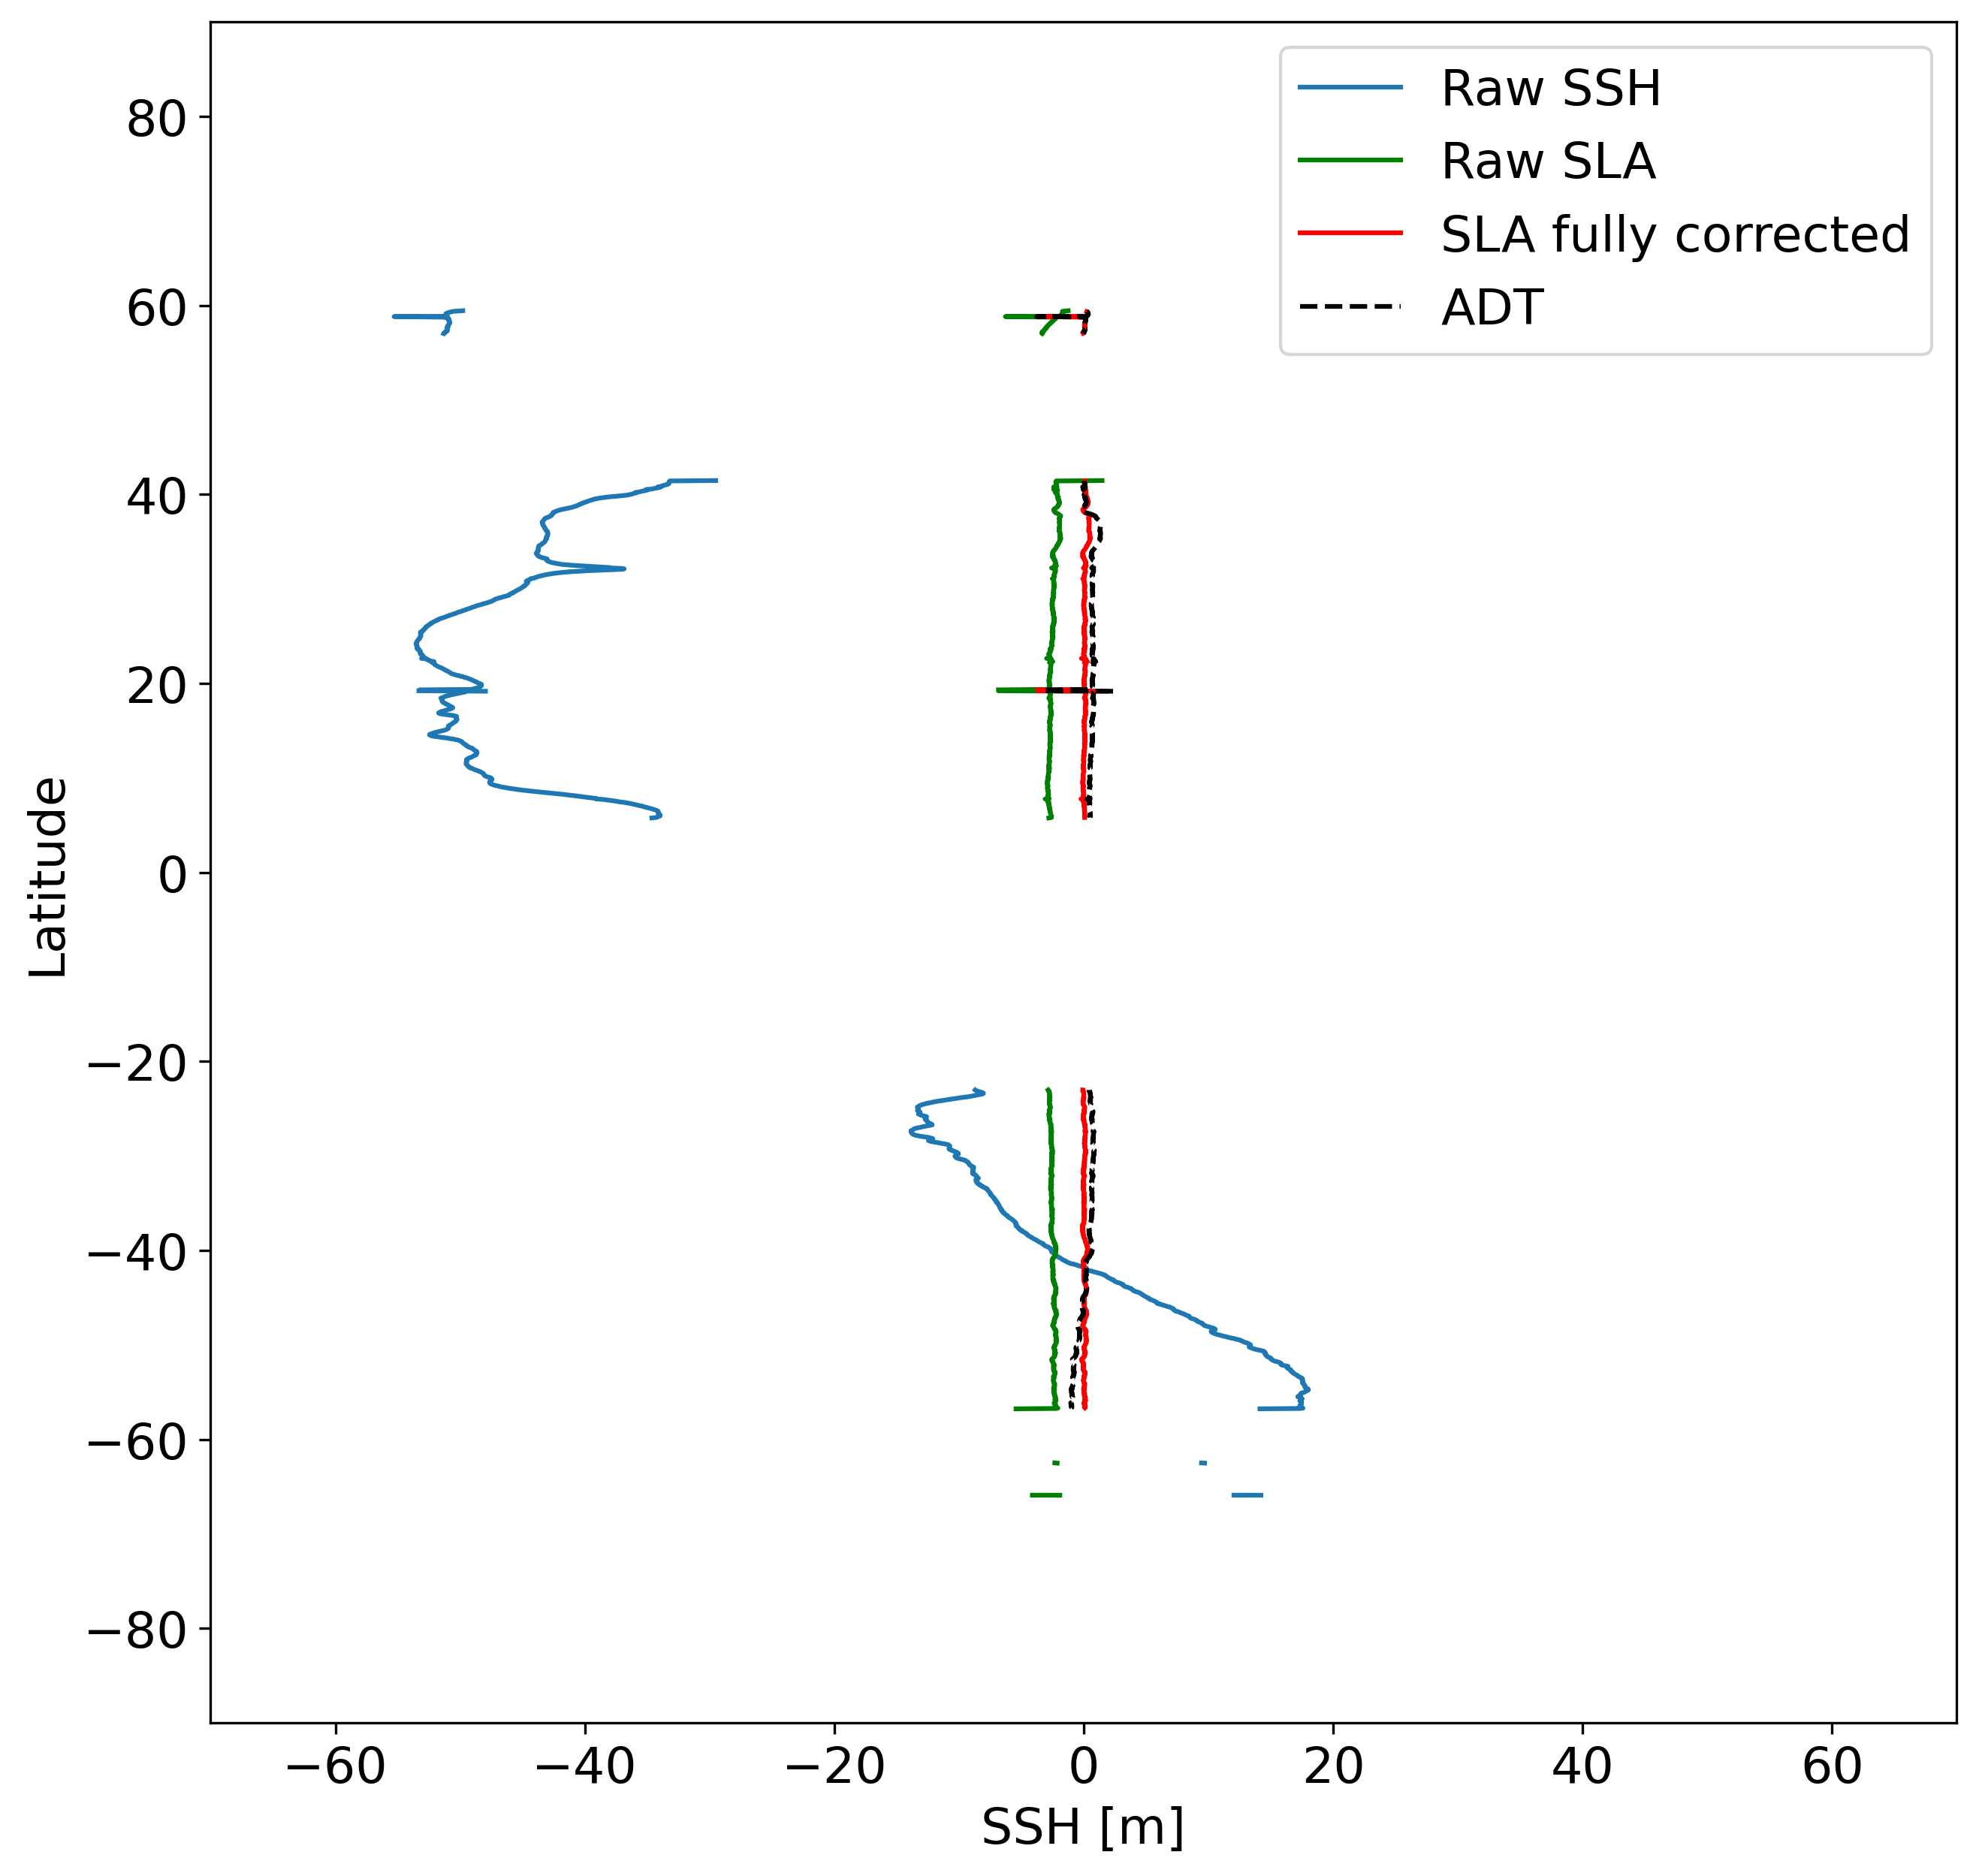

In [5]:
# here are intermediate computations of ssh and sla
# usually, only the full corrected ones are used
raw_ssh = alt - range_ku
raw_sla = (alt - range_ku) - mean_sea_surface
sla_ionocorr = ((alt - range_ku) - mean_sea_surface) - iono_corr_alt_ku
sla_iono_drytropocorr = sla_ionocorr - model_dry_tropo_corr
sla_iono_radtropocorr = sla_iono_drytropocorr - rad_wet_tropo_corr
tides = ocean_tide_sol + solid_earth_tide + pole_tide + ocean_tide_non_eq + internal_tide
sla_iono_tropo_tides_corr = sla_iono_radtropocorr - tides
sla_iono_tropo_tides_ssb_corr = sla_iono_tropo_tides_corr - sea_state_bias_ku
sla_fullcorr = sla_iono_tropo_tides_ssb_corr - hf_fluctuations_corr
adt = sla_fullcorr + mean_topography

## NEW in Sentinel-6 : ocean_geo_correction available in ku/ group
#Sum of meteorological and geophysical corrections to be applied to SSHA over ocean: 
#altimeter ionospheric correction (iono_cor_alt_filtered) 
#+ model dry tropospheric correction at zero altitude (model_dry_tropo_cor_zero_altitude)
#+ radiometer wet tropospheric correction (rad_wet_tropo)
#+ sea state bias correction (sea_state_bias)
#+ solid earth tide height (solid_earth_tide) 
#+ geocentric ocean tide height solution 2 (FES) (ocean_tide_sol2) 
#+ non-equilibrium long-period geocentric ocean tide height (ocean_tide_non_eq)
#+ internal tide (internal_tide)
#+ geocentric pole tide height (pole_tide)
#+ dynamic atmospheric correction (dac for NTC/STC off line products, inv_bar_cor for NRT products)

ocean_geo_corrections = ncku.variables['ocean_geo_corrections']
#then
sla = (alt - range_ku) - ocean_geo_corrections - mean_sea_surface

#plot e.g. a "raw" version of SSH (un-corrected) and the corrected SLA
fig = plt.figure(figsize=(10, 10), dpi=300)
ax = plt.subplot(1,1,1)
p1, = ax.plot(raw_ssh, lat, label='Raw SSH')
p2, = ax.plot(raw_sla, lat, 'g', label='Raw SLA')
p3, = ax.plot(sla_fullcorr, lat, 'r', label='SLA fully corrected')
p4, = ax.plot(adt, lat, 'k--', label='ADT')
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels)
plt.axis([-70, 70, -90, 90])
plt.xlabel('SSH [m]', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.show()


Note the amplitude of the SSH.

## Looking at a major current ##

the graph above shows a whole track (half orbit); a smaller area can be easier to interpret. We will focus on the North Atlantic (Gulf Stream), i.e. restrict the graph to a latitude between 0 and 45°N. 
You may need to adapt the axis to the area/date you are looking at. Zoom over another region and look at the extrema values

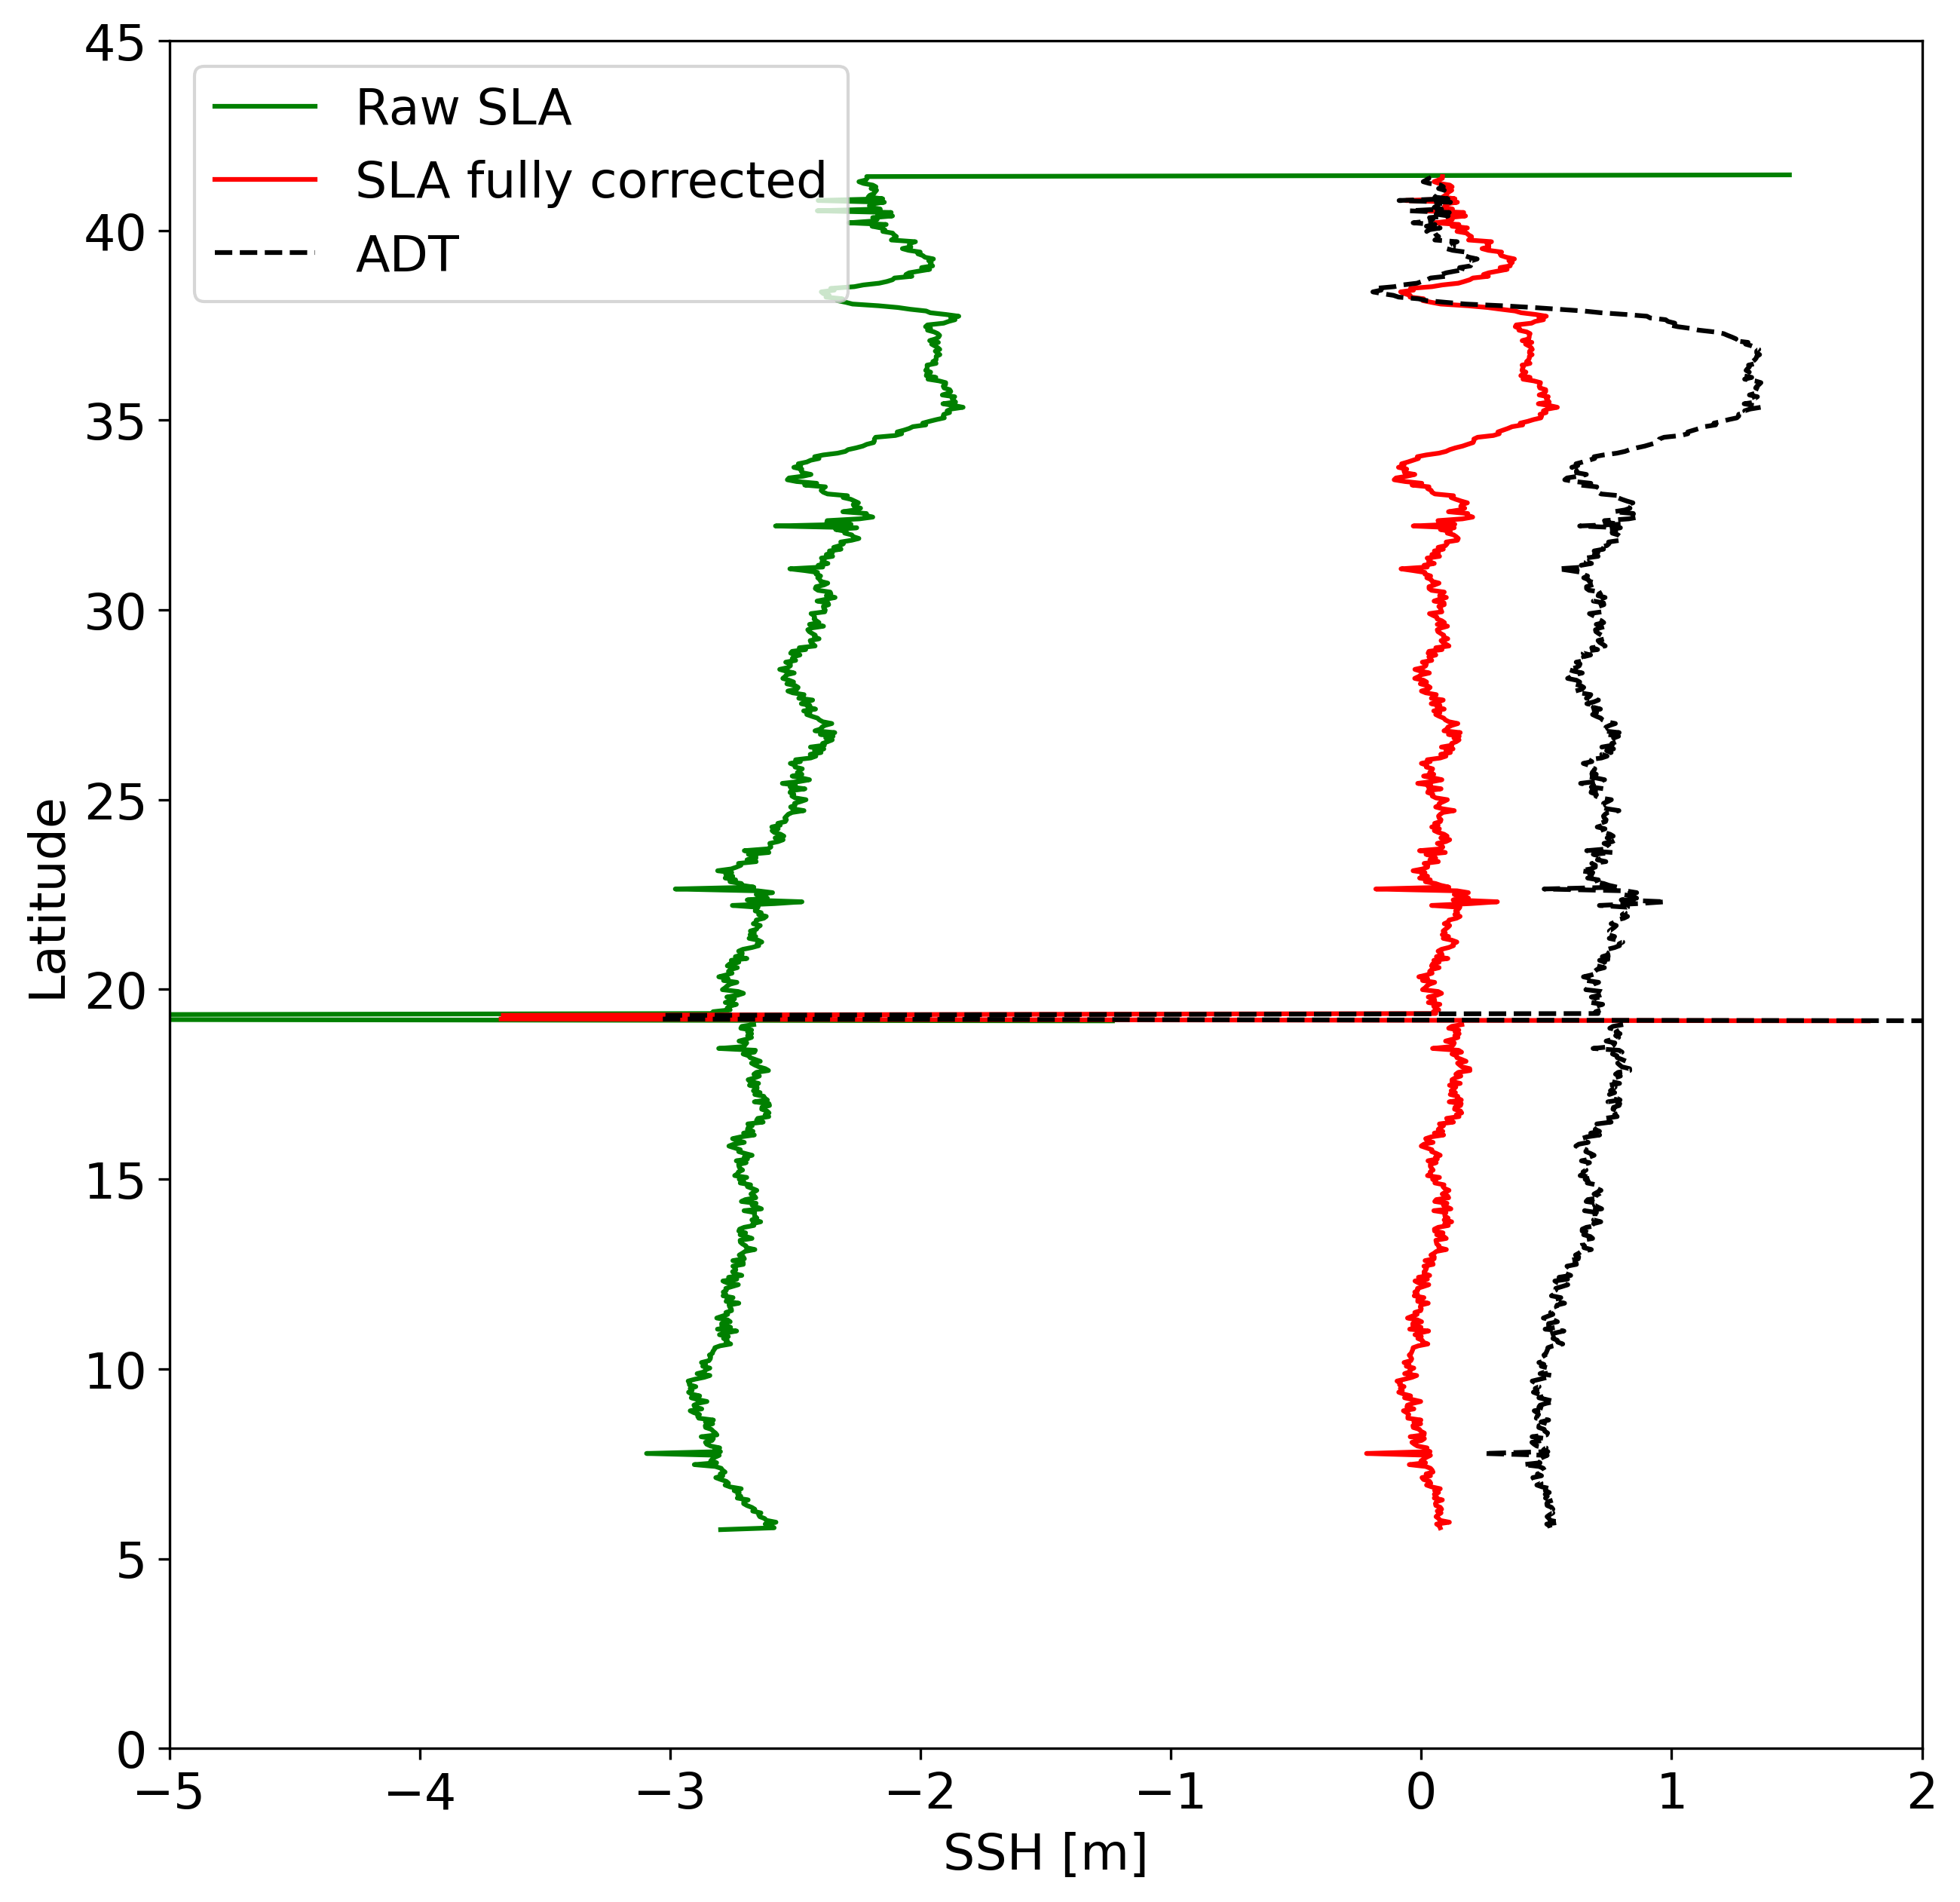

In [6]:
# zoom on an area and adapt the scale 
fig = plt.figure(figsize=(10, 10), dpi=300)
ax = plt.subplot(1,1,1)
#p1, = ax.plot(raw_ssh, lat, label='Raw SSH')
p2, = ax.plot(raw_sla, lat, 'g', label='Raw SLA')
p3, = ax.plot(sla_fullcorr, lat, 'r', label='SLA fully corrected')
p4, = ax.plot(adt, lat, 'k--', label='ADT')
# modify the third and fourth values below to adapt the y scale (NB. we are working in meters, for raw ssh)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels)
plt.axis([-5, 2, 0, 45])
plt.xlabel('SSH [m]', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.show()

the "bump" on the curve around 35-38°N corresponds to the Gulf Stream main flow; in SLA it is more its turbulence which is seen, in ADT the main gyre. 

## Tests on the variables over the Gulf Stream area ##

Try and test different variables as defined above - corrections and intermediate ssh values
modify the min/max value to better see the amplitude of the curves ends up with sla_fullcorr

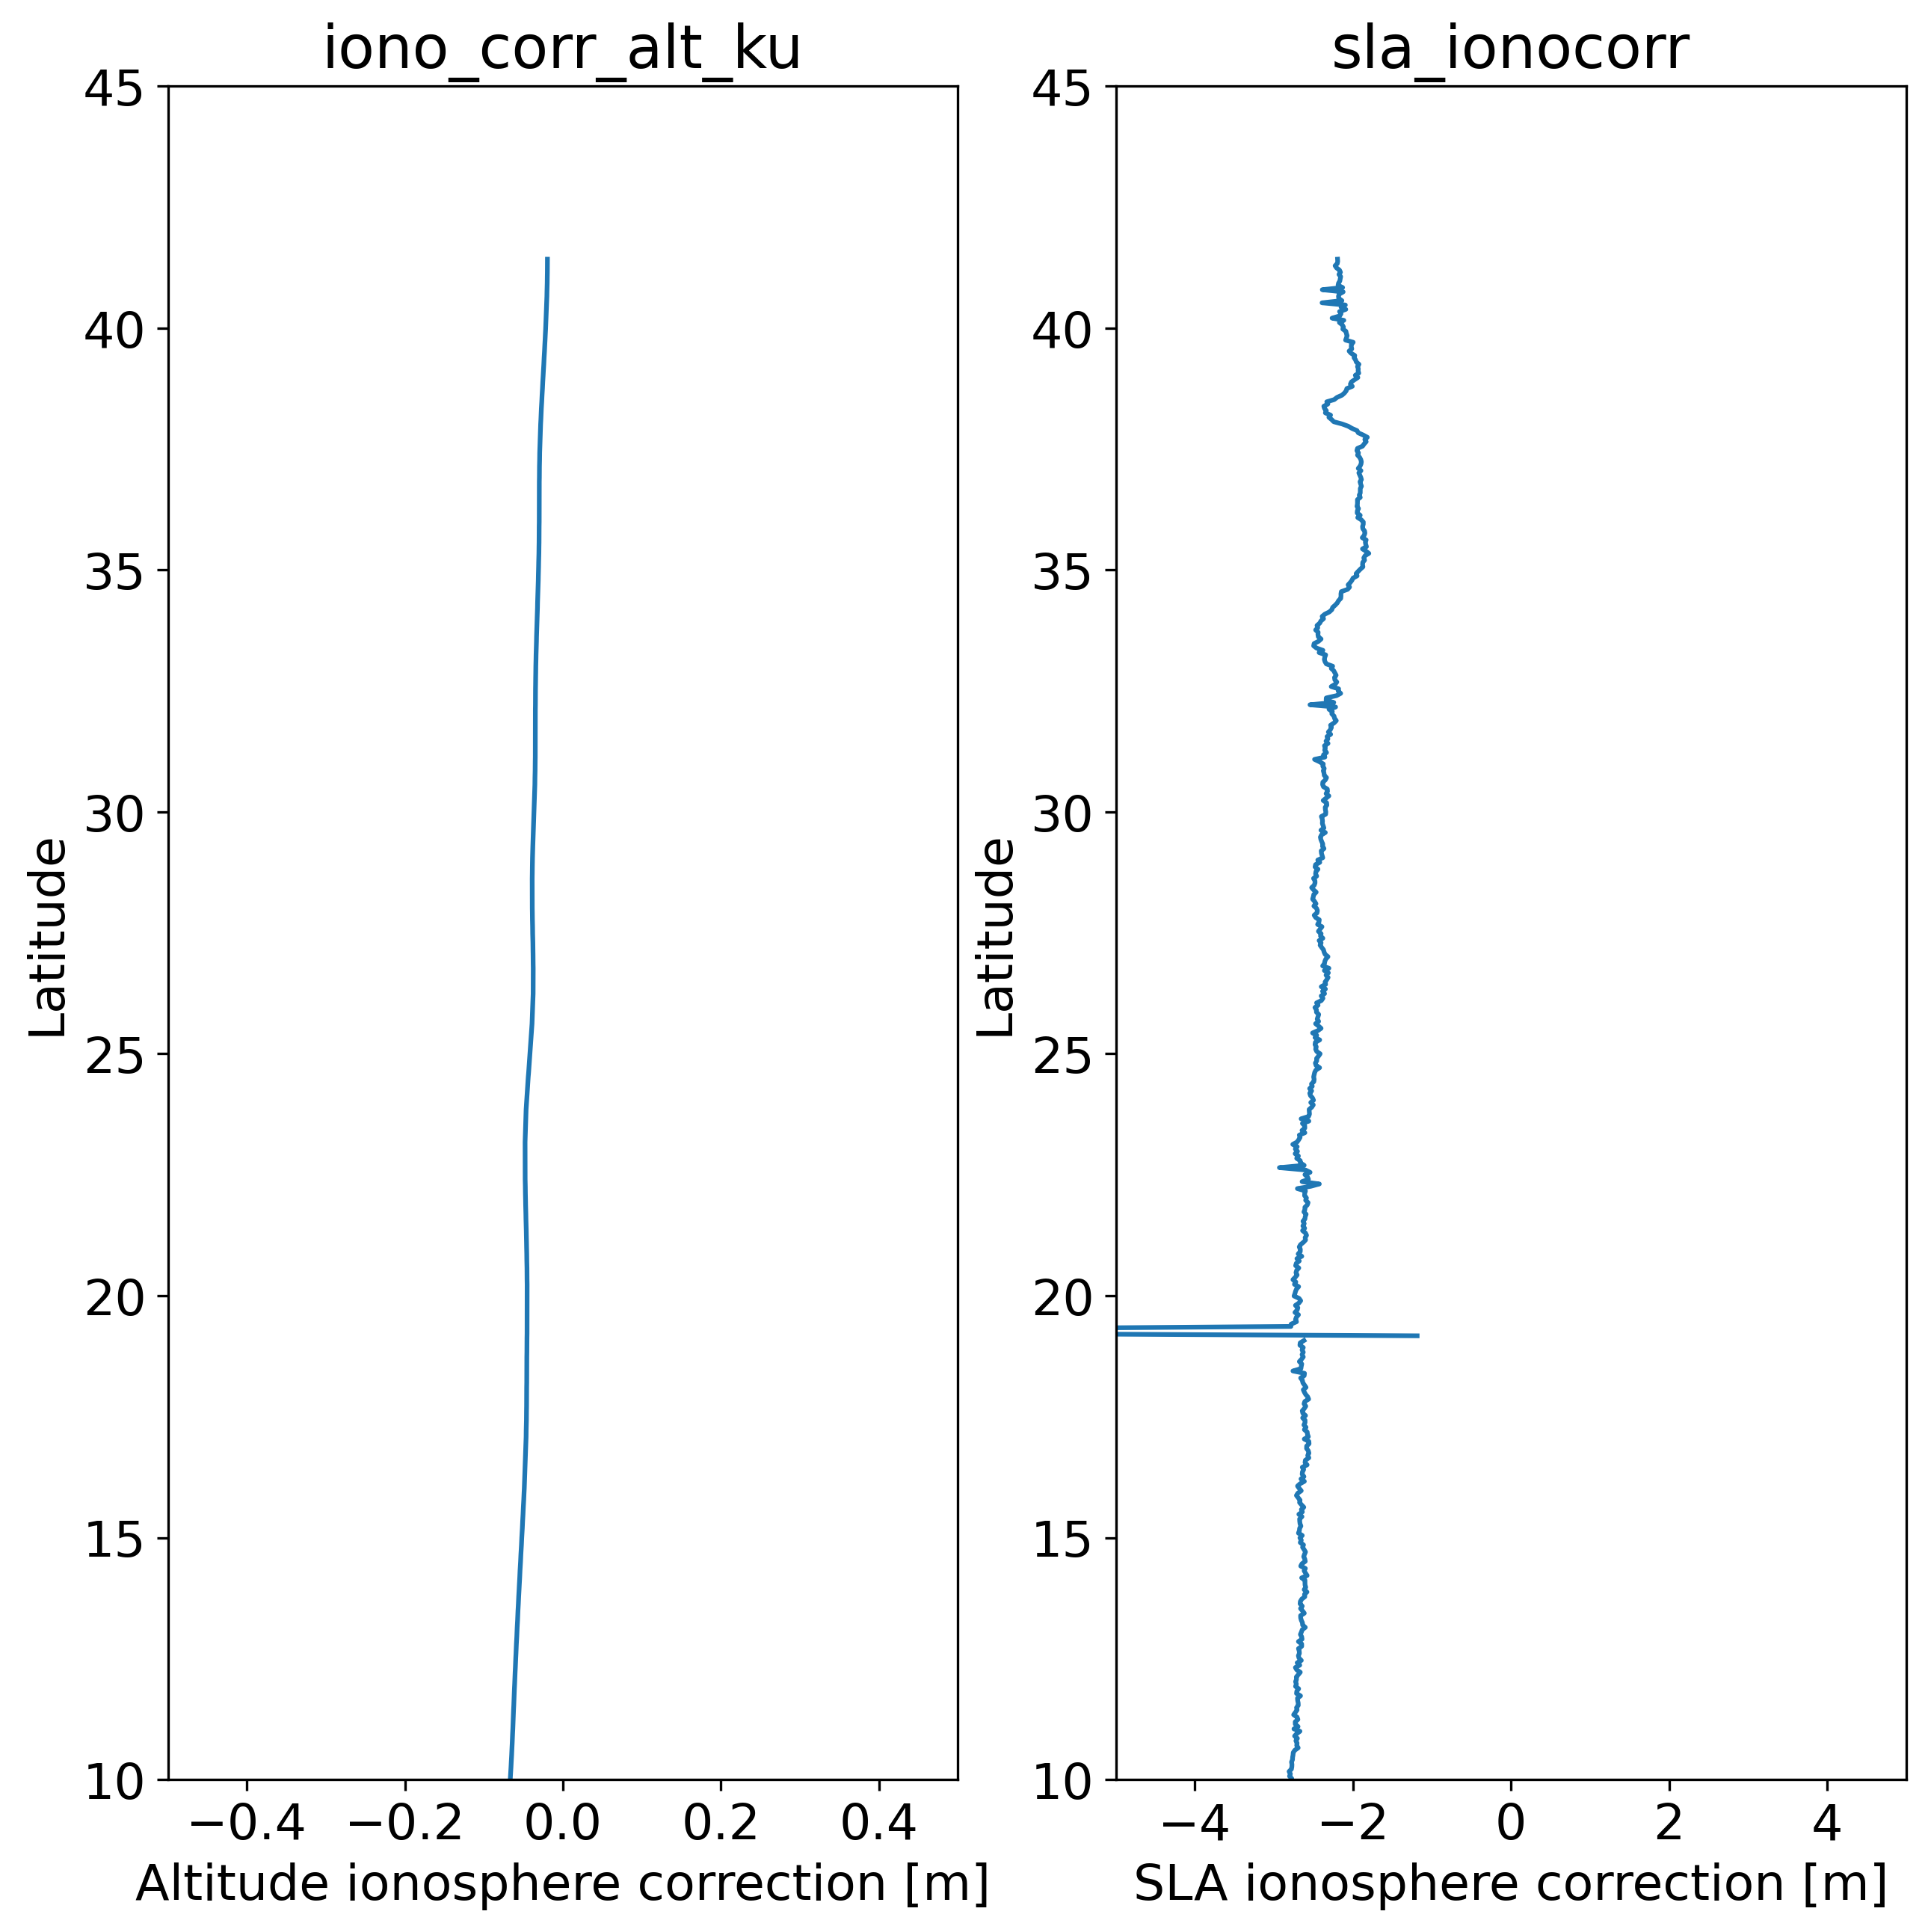

In [7]:
fig1 = plt.figure(figsize=(10, 10), dpi=300)
ax = plt.subplot(1,2,1)
p1 = ax.plot(iono_corr_alt_ku, lat)
plt.title('iono_corr_alt_ku')
plt.xlabel('Altitude ionosphere correction [m]', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.axis([-0.5, 0.5, 10, 45])
ax = plt.subplot(1,2,2)
ax.plot(sla_ionocorr, lat)
plt.title('sla_ionocorr')
plt.xlabel('SLA ionosphere correction [m]', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.axis([-5, 5, 10, 45])
plt.show()

You can apply the computation to a whole cycle or a regional area of a whole cycle and map it.
Note that if you mix SLA computed like this from several satellites (e.g. from Sentinel-3), you will have biases and other differences between them. The exception is the intercalibrated series Topex/Poseidon - Jason-1 - Jason-2 - Jason-3 - Sentinel-6A (Michael Freilich). Which is why you may see the latter called 'Jason-CS' CS for 'Continuity of Service'

<br> <a href="3_SRAL_Tracks.ipynb">3 - SRAL tracks</a><span style="float:right;"><a href="./5_SRAL_Waveforms.ipynb">5 - SRAL waveforms >></a>  
    
<a href="https://gitlab.eumetsat.int/eumetlab/ocean">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int>Contact helpdesk for support </a> | <a href=mailto:Copernicus.training@eumetsat.int>Contact our training team to collaborate on and reuse this material</a></span></p>